# Notebook Demonstration for XGFood & Evaluator

## Imports & Settings

In [2]:
import pandas as pd
from IPython.lib.deepreload import reload as dreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
import time

In [3]:
data = pd.read_csv(r'files\data_raw_for_classes.csv')

In [5]:
X_raw = data[['product_name', 'ingredients']].sample(1000, random_state=42)
y_G1 = data['pnns_groups_1'].sample(1000, random_state=42).reset_index(drop=True)
y_G2 = data['pnns_groups_2'].sample(1000, random_state=42).reset_index(drop=True)

In [6]:
X_raw

,product_name,ingredients
67386,Brassé framboise mûre,"[{'percent_min': 64.8, 'vegetarian': 'yes', 't..."
84890,Confiture,"[{'percent': '60', 'percent_estimate': 60, 'ra..."
55093,Sardines citron-basilic,"[{'vegetarian': 'no', 'vegan': 'no', 'text': '..."
40660,Quenelles lyonnaises de brochet,"[{'id': 'fr:OEufs frais 31', 'text': 'OEufs fr..."
99651,Poires Demi-fruits au sirop léger,"[{'id': 'fr:Demi-poires Williams', 'text': 'De..."
...,...,...
89013,Cuisses de grenouilles congelées,"[{'percent_max': 100, 'id': 'en:frog-legs', 'p..."
137655,Brocoli Mix,"[{'percent_estimate': 34, 'rank': 1, 'percent'..."
4230,Jambon cuit supérieur,"[{'percent_estimate': 56.25, 'rank': 1, 'origi..."
13765,Jambon traditionnel,"[{'id': 'fr:Jambon de qualité supérieur', 'tex..."


# Model Predictions

In [4]:
from XGFood import XGFood
model = XGFood()

## 1. Process in predict method

# predict method

*(method) model.predict: (
    X,
    decode_labels=True,
    pred_format='pd',
    get_confidence=True,
    preprocess=True
)*

**Get predictions of G1 and G2 with XGBoost models, with optional confidences levels.**

## Parameters

    - X (pd.DataFrame or np.array) : Features inputs. Can be already preprocessed (shape N samples, 938 features) 
    or not (set preprocess=True) 
    - decode_labels(Bool, default = True) : Return original labels (string) instead of encoded (int). 
    - pred_format(default = 'pd'): 
        - 'pd' : Return a dataframe with predictions for G1, G2 and confidences if get_confidence set to True
        - 'np' : return a numpy array with predictions and confidences if get_confidence set to True.
    - get_confidence(Bool, default = True) : Get level of confidence for each prediction. 
    - preprocess(Bool, default=True) : preprocess X before fit the model.

## Return

**A DataFrame (or an array if pred_format = 'np') with 1 row per prediction:** 

    - y_pred_G1 : predictions for group 1 (9 labels + 'y_unknown') 
    - y_pred_G2 : predictions for group 2 (38 labels + 'y_unknown') 
    - if get confidences set to True: 
        - y_conf_G1 : level of confidence for every G1 prediction 
        - y_conf_G2 : level of confidence for every G2 prediction

In [37]:
%%time
predictions = model.predict(X_raw)

Wall time: 1.69 s


In [9]:
predictions

,y_pred_G1,y_conf_G1,y_pred_G2,y_conf_G2
0,milk and dairy products,0.90,milk and yogurt,0.93
1,sugary snacks,0.99,sweets,0.98
2,fish meat eggs,0.97,fish and seafood,0.99
3,composite foods,0.67,one dish meals,0.98
4,fruits and vegetables,1.00,fruits,0.97
...,...,...,...,...
995,fish meat eggs,0.62,meat,0.85
996,y_unknown,0.00,vegetables,0.10
997,fish meat eggs,1.00,processed meat,0.99
998,fish meat eggs,0.98,processed meat,0.98


## 2. Process -> Predict

In [36]:
X = model.process_X(X_raw)

Processing done - Total running time : 0.1mn


In [8]:
predictions = model.predict(X_raw, preprocess=False)

Processing done - Total running time : 0.09mn


# Evaluation

In [21]:
from Evaluator import Evaluator
evaluation = Evaluator()

## build_data

*(method) evaluation.build_data: (
    y_true,
    y_pred,
    y_confidence=None,
    pred_type=None,
    decode_labels=False,
    label_encoder='from_existing',
)*

**Create the dataset used for other methods**

### Arguments

    - y_true = true labels
    - y_pred = predicted labels
    - y_confidence = if passed, the confidence level for preds in y_pred.
    - pred_type = (default None) Can be 'G1', 'G2' or other (None or 'tags' for example).
        - 'G1' : PNNS_Groups_1, 9 possible labels. Used for label_decoder
        - 'G2' : PNNS_Groups_2, 38 possible labels. Used for label_decoder 
    - decode_labels = If true, use a label encoder to decode labels. 
    - label_encoder = The label encoder used for decode labels if decode_labels == True.
    if label_encoder = 'from_existing' : load the label encoder for the pred type passed in pred_type.

### Return

A dataframe with columns :
    - y_true,
    - y_pred,
    - pred_is_true : 1 if y_true == y_pred else 0
    - pred_confidence : y_confidence if y_confidence is not None

In [22]:
evaluation.build_data(y_true=y_G1, y_pred=predictions['y_pred_G1'], y_confidence=predictions['y_conf_G1'])

,y_true,y_pred,pred_is_true,pred_confidence
0,milk and dairy products,milk and dairy products,1,0.90
1,sugary snacks,sugary snacks,1,0.99
2,fish meat eggs,fish meat eggs,1,0.97
3,composite foods,composite foods,1,0.67
4,fruits and vegetables,fruits and vegetables,1,1.00
...,...,...,...,...
995,fish meat eggs,fish meat eggs,1,0.62
996,fruits and vegetables,y_unknown,0,0.00
997,fish meat eggs,fish meat eggs,1,1.00
998,fish meat eggs,fish meat eggs,1,0.98


## Global Classification Metrics

*(method) evaluation.global_metrics: (average='weighted', name='Model', zero_div=0)
Return Accuracy, Recall, Precision and F-1 score. Average can take two arguments : macro or weighted*

In [16]:
evaluation.global_metrics(name='XGBoost G1')

XGBoost G1 Classification Metrics :
-----------------------------------
Accuracy : 85.10%
Recall : 85.10%
Precision : 95.23%
F1-score : 89.77%




## Structured Classification Report

*(method) evaluation.classification_report: (
    sortby='precision',
    name='model',
    save_report=False,
    report_path='classification_report.csv',
)*

In [17]:
evaluation.classification_report(sortby='precision', name='XGBoost G1')

,XGBoost G1_precision,XGBoost G1_recall,XGBoost G1_f1-score,XGBoost G1_support
fat and sauces,0.98,0.90,0.94,63.00
milk and dairy products,0.98,0.89,0.93,131.00
fish meat eggs,0.97,0.88,0.92,135.00
beverages,0.97,0.77,0.86,108.00
salty snacks,0.96,0.83,0.89,58.00
sugary snacks,0.96,0.94,0.95,214.00
weighted avg,0.95,0.85,0.90,1000.00
composite foods,0.93,0.83,0.88,101.00
cereals and potatoes,0.92,0.74,0.82,111.00
fruits and vegetables,0.90,0.76,0.82,79.00


## Scores per category with pointplot

*(method) evaluation.plot_categories_scores: (
    metric='precision',
    name='Model',
    figsize=(8, 10),
    save_fig=False,
    fig_path='score_by_category.png',
)
Point plot with metric score by category, sorted by metric*

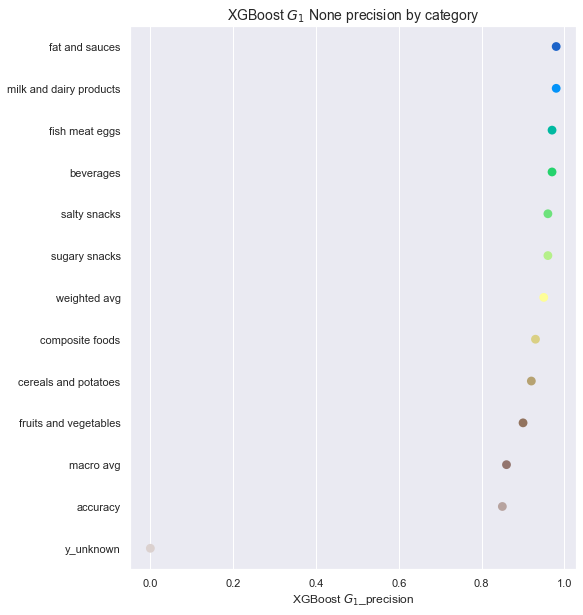

In [18]:
evaluation.plot_categories_scores(metric='precision', name=r'XGBoost $G_1$')

## Level of confidence per category with KDE Plot

*(method) evaluation.plot_confidence: (
    name='Model',
    metric='precision',
    col_wrap=5,
    save_fig=False,
    fig_path='confidence_by_category.png',
)
Print a KDE Plot with model confidence for every category*

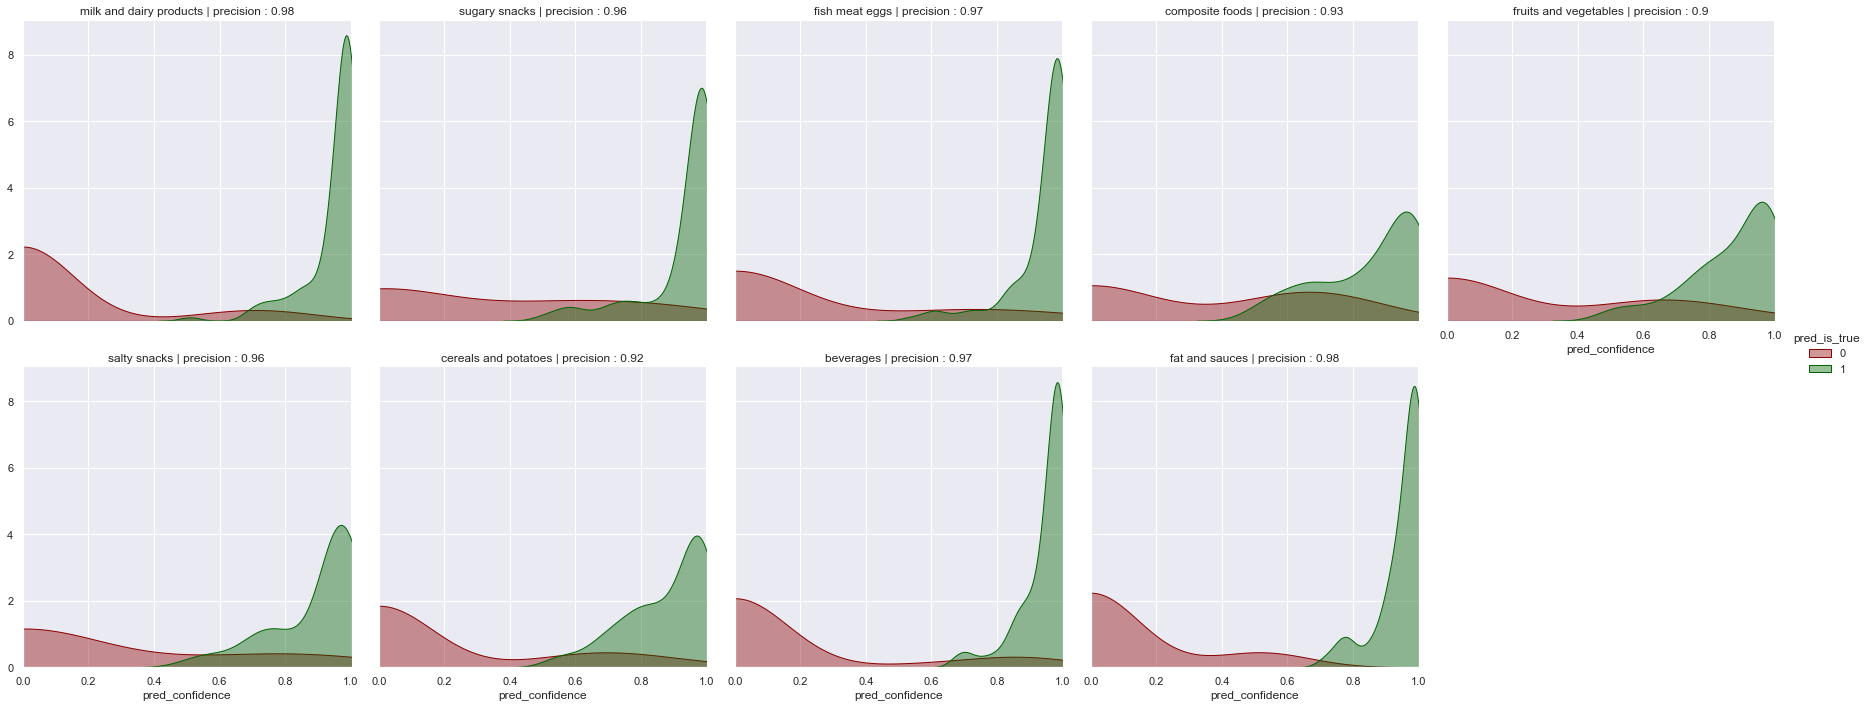

In [19]:
evaluation.plot_confidence()

## Confusion Matrix with heatmap

*(method) evaluation.plot_confusion_matrix: (
    name='Model',
    figsize=(20, 15),
    annot=True,
    cmap='Greens',
    save_fig=False,
    fig_path='confidence_by_category.png',
)
Return a confusion matrix with seaborn heatmap design*

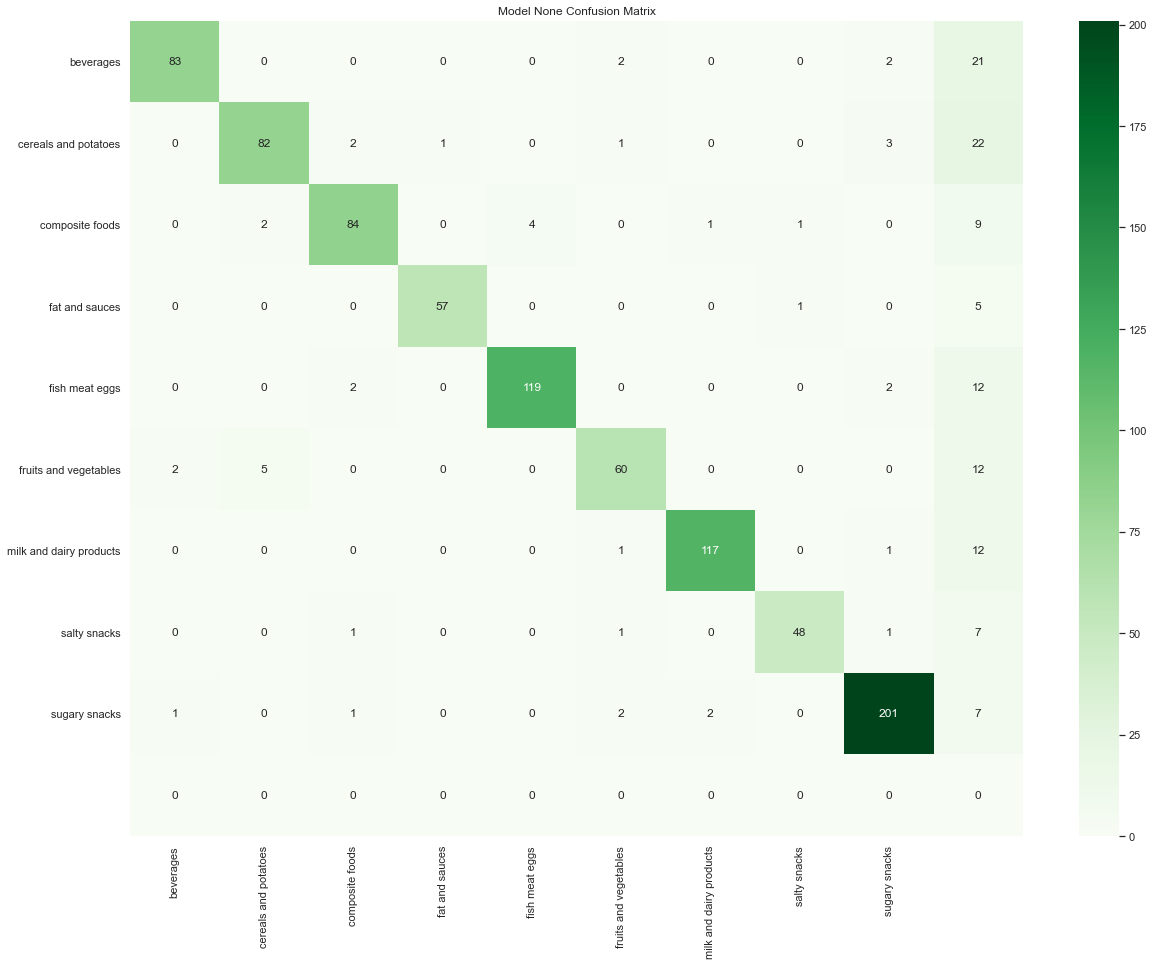

In [20]:
evaluation.plot_confusion_matrix()